# Make and Train a Simple MPNN
Train an MPNN to predict the IC50

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from molgym.mpnn.layers import GraphNetwork, Squeeze
from molgym.mpnn.data import make_data_loader
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks as cb
from scipy.stats import spearmanr, kendalltau
import tensorflow as tf
import numpy as np
import json

## Make the Data Loaders
Use a utility function from `molgym.mpnn`. Make one for the training, validation and test sets

In [2]:
train_loader = make_data_loader('train_data.proto', shuffle_buffer=1024)

In [3]:
val_loader = make_data_loader('val_data.proto')

In [4]:
test_loader = make_data_loader('test_data.proto')

## Make a Model
Make a simple MPNN

First, determine the size of the atom and bond vocabulary

In [5]:
with open('atom_types.json') as fp:
    atom_type_count = len(json.load(fp))
with open('bond_types.json') as fp:
    bond_type_count = len(json.load(fp))

In [6]:
def build_fn(atom_features=64, message_steps=8):
    node_graph_indices = Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = Input(shape=(1,), name='atom', dtype='int32')
    bond_types = Input(shape=(1,), name='bond', dtype='int32')
    connectivity = Input(shape=(2,), name='connectivity', dtype='int32')
    
    # Squeeze the node graph and connectivity matrices
    snode_graph_indices = Squeeze(axis=1)(node_graph_indices)
    satom_types = Squeeze(axis=1)(atom_types)
    sbond_types = Squeeze(axis=1)(bond_types)
    
    output = GraphNetwork(atom_type_count, bond_type_count, atom_features, message_steps,
                          output_layer_sizes=[512, 256, 128],
                          attention_mlp_sizes=[256, 128],
                          atomic_contribution=True, reduce_function='attention',
                          name='mpnn')([satom_types, sbond_types, snode_graph_indices, connectivity])
    
    # Scale the output
    output = Dense(1, activation='linear', name='scale')(output)
    
    return Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity],
                 outputs=output)

In [7]:
model = build_fn(atom_features=256, message_steps=8)

Get the mean and standard deviation of the training set. Use it to set the scale model

In [8]:
ic50s = np.concatenate([x[1].numpy() for x in iter(train_loader)], axis=0)

In [9]:
model.get_layer('scale').set_weights([np.array([[ic50s.std()]]), np.array([ic50s.mean()])])

## Train the Model
Train the model using Adam as the optimizer and MSE loss

In [10]:
model.compile(Adam(InverseTimeDecay(1e-3, 64, 0.5)), 'mean_squared_error', metrics=['mean_absolute_error'])

In [11]:
history = model.fit(val_loader, validation_data=val_loader, epochs=1024, verbose=False, 
                   shuffle=False, callbacks=[
                       cb.ModelCheckpoint('best_model.h5', save_best_only=True),
                       cb.EarlyStopping(patience=128, restore_best_weights=True),
                       cb.CSVLogger('train_log.csv'),
                       cb.TerminateOnNaN()
                   ])

/home/wardlt/miniconda3/envs/covid_dqn-conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/covid_dqn-conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda3/envs/covid_dqn-conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/wardlt/miniconda

Text(0.5, 0, 'epoch')

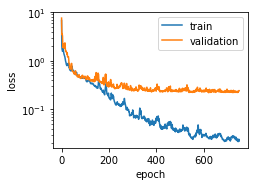

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(history.epoch, history.history['loss'], label='train')
ax.semilogy(history.epoch, history.history['val_loss'], label='validation')

ax.legend()
ax.set_ylabel('loss')
ax.set_xlabel('epoch')

## Validate the Model
Run against the hold out set

In [13]:
y_true = np.hstack([x[1].numpy()[:,0] for x in iter(test_loader)])

In [14]:
y_pred = np.squeeze(model.predict(test_loader))

Report some statistics

In [15]:
print(f'R^2: {np.corrcoef(y_true, y_pred)[1, 0] ** 2: .2f}')
print(f'Spearman R: {spearmanr(y_true, y_pred)[0]: .2f}')
print(f'Kendall Tau: {kendalltau(y_true, y_pred)[0]: .2f}')
print(f'MAE: {np.mean(np.abs(y_pred - y_true)): .2f} (MAD: {np.mean(np.abs(y_true - np.mean(y_true))): .2f})')

R^2:  0.57
Spearman R:  0.68
Kendall Tau:  0.50
MAE:  0.84 (MAD:  1.52)


Text(0, 0.5, 'p(IC50), MPNN')

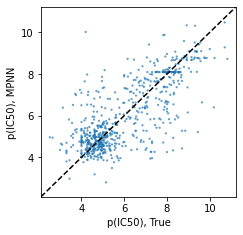

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(y_true, y_pred, s=5, alpha=0.7, edgecolor='none')

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('p(IC50), True')
ax.set_ylabel('p(IC50), MPNN')

## Save the Model
For later use, in case we want the last model

In [17]:
model.save('model.h5')